<a href="https://colab.research.google.com/github/kmayutrisna/SA_IMDB/blob/main/1_IMDB_Keras_CNN_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#DATA PREPARATION
# Importing essential libraries and functions
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

**DATA COLLECTION**

In [ ]:
#Get the dataset from gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Display top of data
data =pd.read_csv("drive/My Drive/data/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
#Display shape and data info
data.review.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
# Checking for missing values
data.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

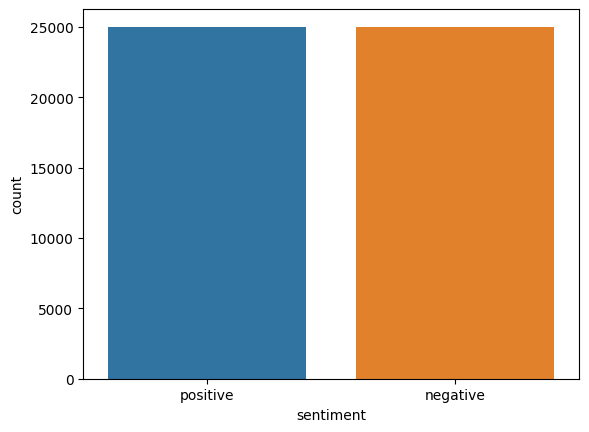

In [ ]:
# Let's observe distribution of positive / negative sentiments in dataset
import seaborn as sns
sns.countplot(x='sentiment', data=data)

**DATA PREPROCESSING**

In [ ]:
#Display the original dara in review coloumn
data["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
  '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''
  return TAG_RE.sub('', text)

In [ ]:
data["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def preprocess_text(sen):
     '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
     in lowercase'''
    
     sentence = sen.lower()

      #Remove html tags
     sentence = remove_tags(sentence)

      #Remove punctuations and numbers
     sentence = re.sub('[^a-zA-Z]', ' ', sentence)

      #Single character removal
     sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

      #Remove multiple spaces
     sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

     # Remove Stopwords
     pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
     sentence = pattern.sub('', sentence)

     return sentence

In [ ]:
# Calling preprocessing_text function on movie_reviews

#X = []
#sentences = list(data['review'])
#for sen in sentences:
 #   X.append(preprocess_text(sen))

#Display datas that has been cleaned
data['processed'] = data['review'].apply(lambda x: preprocess_text(x))
data.head()

,review,sentiment,processed
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...


In [ ]:
# Sample cleaned up movie review 

data['processed'][2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [ ]:
#Data Processing
#Provide a sentiment class with a label. 1 if positive and 0 if negative.
data['Label'] = data['sentiment'].apply(lambda x: 0 if x == 'negative' else 1)
data.head()

,review,sentiment,processed,Label
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode ho...,1
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,1
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,1
3,Basically there's a family where a little boy ...,negative,basically family little boy jake thinks zombie...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...,1


**TOKENIZER AND SPLIT DATASET**

In [ ]:
#Tokenize the text, Any unknown word will be replaced by oov_token
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(oov_token="<OOV>")

In [ ]:
# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
train_size=0.8
X = data['processed']
y = data['Label']

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(40000,)
(40000,)
(5000,)
(5000,)
(5000,)
(5000,)


(None, None)

In [ ]:
X_test

33553    really liked summerslam due look arena curtain...
9427     many television shows appeal quite many differ...
199      film quickly gets major chase scene ever incre...
12447    jane austen would definitely approve one gwyne...
39489    expectations somewhat high went see movie thou...
                               ...                        
28567    although casper van dien michael rooker genera...
25079    liked movie really sure started watching enjoy...
18707    yes non singaporean see big deal film referenc...
15200    far films go likable enough entertaining chara...
5857     saw anatomy years ago dubbed friends house rem...
Name: processed, Length: 10000, dtype: object

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 150
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

**PAD THE SEQUENCE**

In [ ]:
# Convert texts to sequences
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, truncating=trunc_type)
val_seq = tokenizer.texts_to_sequences(X_valid)
val_padded = pad_sequences(val_seq, maxlen=max_length, truncating=trunc_type)
test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq, maxlen=max_length, truncating=trunc_type)

#sequences = tokenizer.texts_to_sequences(X_train)
#padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
#testing_sentences = tokenizer.texts_to_sequences(X_train)
#testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [ ]:
train_padded

array([[ 657, 1984,   33, ..., 1092,  186, 2715],
       [   0,    0,    0, ...,   23, 1546,   28],
       [   0,    0,    0, ...,  198,  570,   10],
       ...,
       [   0,    0,    0, ...,  980, 1472,  461],
       [   0,    0,    0, ...,   28, 6818,    1],
       [   0,    0,    0, ...,  346,   14, 1809]], dtype=int32)

**1-D Convolutions over text**

In [ ]:
from tensorflow.keras.layers import Dense, Embedding,GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding

base_model = Sequential()
base_model.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
base_model.add(Conv1D(64, 5, activation='relu'))
base_model.add(GlobalMaxPooling1D())
base_model.add(Flatten())
base_model.add(Dense(units=64, activation='relu'))
base_model.add(Dropout(0.3))
base_model.add(Dense(units=1, activation='sigmoid'))


In [ ]:
# Model compiling
from tensorflow import keras
from tensorflow.keras.metrics import AUC

#base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC(curve='ROC'), keras.metrics.AUC(curve='PR')])

print(base_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 146, 64)           5184      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [ ]:
# Train model
history = base_model.fit(train_padded, y_train, epochs=10, batch_size=32, validation_data=(val_padded, y_valid))

loss, acc, auc_roc, auc_pr = base_model.evaluate(val_padded, y_valid, verbose=0)
print('Validation accuracy: ', acc)
print('Validation AUC-ROC: ', auc_roc)
print('Validation AUC-PR: ', auc_pr)

Epoch 1/10
1250/1250 [==============================] - 19s 14ms/step - loss: 0.4000 - acc: 0.8092 - auc: 0.8989 - auc_1: 0.8959 - val_loss: 0.3390 - val_acc: 0.8524 - val_auc: 0.9367 - val_auc_1: 0.9362
Epoch 2/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.2333 - acc: 0.9100 - auc: 0.9662 - auc_1: 0.9640 - val_loss: 0.3229 - val_acc: 0.8632 - val_auc: 0.9409 - val_auc_1: 0.9399
Epoch 3/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.1391 - acc: 0.9519 - auc: 0.9870 - auc_1: 0.9854 - val_loss: 0.3730 - val_acc: 0.8652 - val_auc: 0.9364 - val_auc_1: 0.9340
Epoch 4/10
1250/1250 [==============================] - 17s 13ms/step - loss: 0.0687 - acc: 0.9797 - auc: 0.9958 - auc_1: 0.9948 - val_loss: 0.4687 - val_acc: 0.8588 - val_auc: 0.9312 - val_auc_1: 0.9226
Epoch 5/10
1250/1250 [==============================] - 17s 13ms/step - loss: 0.0303 - acc: 0.9919 - auc: 0.9987 - auc_1: 0.9982 - val_loss: 0.5860 - val_acc: 0.8570 - val_auc: 0.9214 

In [ ]:
# Predicting on the Test dataset.
y_pred = base_model.evaluate(test_padded, y_test)
#y_pred = base_model.predict(test_padded, y_test).flatten()

157/157 [==============================] - 1s 6ms/step - loss: 0.8679 - acc: 0.8584 - auc: 0.9065 - auc_1: 0.8883


In [ ]:
# Model Performance

print("Test Score:", y_pred[0])
print("Test Accuracy:", y_pred[1])

Test Score: 0.8679172992706299
Test Accuracy: 0.8583999872207642


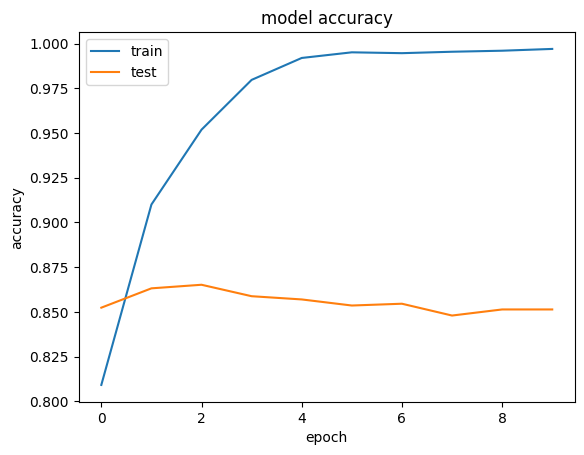

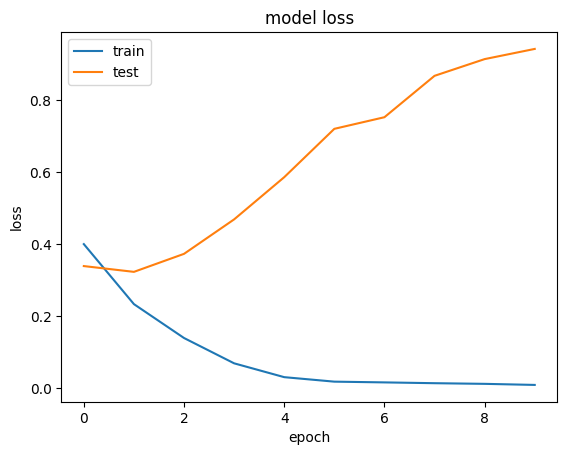

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

157/157 [==============================] - 1s 3ms/step


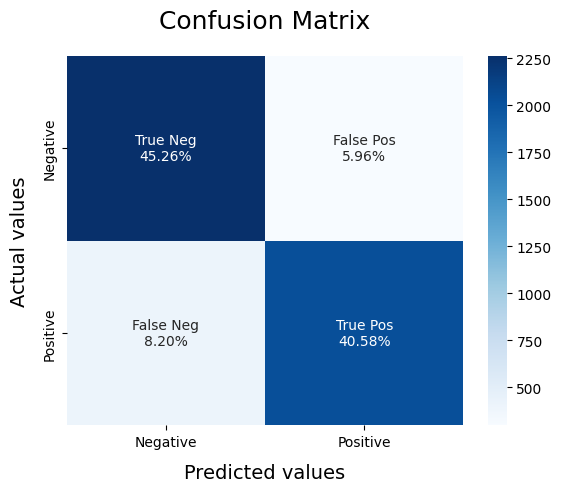

In [ ]:
import seaborn as sns
# Predicting on the Test dataset.
y_pred = base_model.predict(test_padded)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

In [ ]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8466    0.8836    0.8647      2561
           1     0.8719    0.8319    0.8514      2439

    accuracy                         0.8584      5000
   macro avg     0.8593    0.8578    0.8581      5000
weighted avg     0.8590    0.8584    0.8583      5000

